This notebook is a starter kit for the spotGEO competition. It contains examples of how to read the data set, how to use it to train a supervised classifier, and how to apply this classifier to unlabeled images.

# Data handling
The data set is divided into two parts: *train* and *test*. Each of these is composed of *sequences* of *frames* which are stored as .png images. The training set comes with an annotation file named `train_anno.json`. This notebook requires `scikit-learn` and `scikit-image`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from collections import defaultdict

import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import itertools

import random

from skimage import measure

## Reading a single frame

In [2]:
def read_image(path):
    return plt.imread(path)

(480, 640)


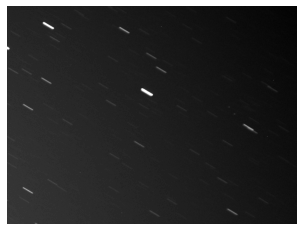

In [4]:
example_image=read_image('./spotGEO/train/1/1.png')
print(example_image.shape)
plt.imshow(example_image, cmap='gray')
plt.axis('off')
plt.show()

## Reading the annotation file

In [5]:
def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict

This creates a dictionary where the first key is the sequence id, and the second key is the frame id, which contains a list of the annotation points as lists of floating numbers. For example sequence \#1 shown above contains 3 objects, which are visible in both frames \#1 and \#3.

In [8]:
train_annotation=read_annotation_file('./spotGEO/train_anno.json')
print(train_annotation[1][1])
print(train_annotation[1][3])

[[502.40625, 237.11458333333337], [490.3818359375, 221.8115234375], [140.87433155080203, 129.09358288770056]]
[[558.40625, 191.11458333333337], [546.3818359375, 175.8115234375], [195.19050802139031, 85.93516042780749]]


# Training a supervised classifier
The idea here is to perform a pixel-wise classification of the image. The training set is generated using the annotations to produce two classes, "1" which represents the geostationary satellites, and "0" which represents their absence.
## Generating labeled data for supervised classification

Next we can generate a training data set using the annotations and the images. For each annotated object, we wish to extract the value of the corresponding pixel in the image, along with the neighboring pixels within a square window of selectable size. Moreover, we will randomly select an arbitrary number of false samples (pixels that contain no satellites) in each image, under the condition that they are different from the training samples.

In [9]:
random.seed(0)

def random_different_coordinates(coords, size_x, size_y, pad):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        c1 = random.randint(pad + 1, size_x - (pad + 1))
        c2 = random.randint(pad + 1, size_y -( pad + 1))
        for c in coords:
            if c1 == c[0] and c2 == c[1]:
                good = False
                break
    return (c1,c2)

def extract_neighborhood(x, y, arr, radius):
    """ Returns a 1-d array of the values within a radius of the x,y coordinates given """
    return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)].ravel()

def check_coordinate_validity(x, y, size_x, size_y, pad):
    """ Check if a coordinate is not too close to the image edge """
    return x >= pad and y >= pad and x + pad < size_x and y + pad < size_y

def generate_labeled_data(image_path, annotation, nb_false, radius):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        if check_coordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
            features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            labels.append(1)
    # False samples
    for i in range(nb_false):
        c = random_different_coordinates(annotation,im_array.shape[1],im_array.shape[0],radius)
        features.append(extract_neighborhood(c[1],c[0],im_array,radius))
        labels.append(0)
    return np.array(labels),np.stack(features,axis=1)

Now we have a function for generating the data for one frame. We can loop this function to generate the labeled data for a list of sequences.

In [10]:
def generate_labeled_set(annotation_array, path, sequence_id_list, radius, nb_false):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    for seq_id in sequence_id_list:
        for frame_id in range(1,6):
            d = generate_labeled_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))

In [12]:
radius=3
train_labels, train_features = generate_labeled_set(train_annotation,'./spotGEO/train/', range(1,101), radius, 10)
print(train_labels.shape)
print(train_labels)
print(train_features.shape)

(5971,)
[1 1 1 ... 0 0 0]
(5971, 49)


This has genered 5971 samples : 971 true and 5000 false (100 sequences, 5 frames per sequence, 10 random false samples per frame). We can reshape the 49 features in a 7x7 window for visualization.
Example of a true sample:

1


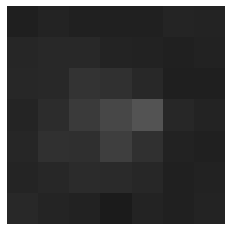

In [13]:
print(train_labels[0])
plt.imshow(train_features[0].reshape((7,7)), cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.show()

Example of a false sample:

0


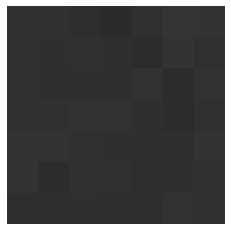

In [14]:
print(train_labels[5])
plt.imshow(train_features[5].reshape((7,7)), cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.show()

## Training the Random Forest

Now the time has come train a classifier on this data! For this example we will use the Random Forest (Breiman et al.) from `scikit-learn`, as well as a few of their classification accuracy metrics. The selected parameters are: number of trees = 500, maximum depth = 30 splits. The others are left at their default values.

In [15]:
RF = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
RF.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [18]:
import pickle

pickle.dump(RF, open('classifier.pkl', 'wb'))

## Testing the Random Forest
We can generate a test set using unseen labeled training samples from the `train` folder to get a first estimation of how this classifier has performed. This time we extract a large number of false samples in each frame.

In [19]:
test_labels, test_features = generate_labeled_set(train_annotation,'./spotGEO/train/', range(101,106), radius, 500)
print(test_labels.shape)
print(test_labels)
print(test_features.shape)

(12575,)
[0 0 0 ... 0 0 0]
(12575, 49)


In [20]:
pred_labels = RF.predict(test_features)
print(classification_report(pred_labels,test_labels))
print(confusion_matrix(pred_labels,test_labels))
print("Kappa =",cohen_kappa_score(pred_labels,test_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12409
           1       0.68      0.31      0.42       166

    accuracy                           0.99     12575
   macro avg       0.84      0.65      0.71     12575
weighted avg       0.99      0.99      0.99     12575

[[12385    24]
 [  115    51]]
Kappa = 0.4184584161627588


As expected, this classifier performs poorly on the true class (labeled "1").

## Classifying a single frame
Now we can use this classifier to perform inference on a single frame (minus the edges), and visualize the result.

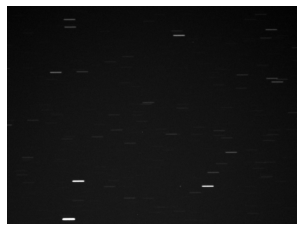

In [22]:
sequence_id, frame_id = 102, 1
target_image = plt.imread(f"./spotGEO/train/{sequence_id}/{frame_id}.png")
plt.imshow(target_image, cmap='gray')
plt.axis('off')
plt.show()

We need to extract the neighborhood features for every pixel in the target image (minus the edges). First we will extract the neighborhoods of all of the pixels in the image. This way we can use only one call to the `predict` function which allows for a more efficient computation.

In [23]:
def classify_image(im, model, radius):
    n_features=(2*radius+1)**2 #Total number of pixels in the neighborhood
    feat_array=np.zeros((im.shape[0],im.shape[1],n_features))
    for x in range(radius+1,im.shape[0]-(radius+1)):
        for y in range(radius+1,im.shape[1]-(radius+1)):
            feat_array[x,y,:]=extract_neighborhood(x,y,im,radius)
    all_pixels=feat_array.reshape(im.shape[0]*im.shape[1],n_features)
    pred_pixels=model.predict(all_pixels).astype(np.bool_)
    pred_image=pred_pixels.reshape(im.shape[0],im.shape[1])
    return pred_image

In [24]:
pred_image=classify_image(target_image, RF, radius)

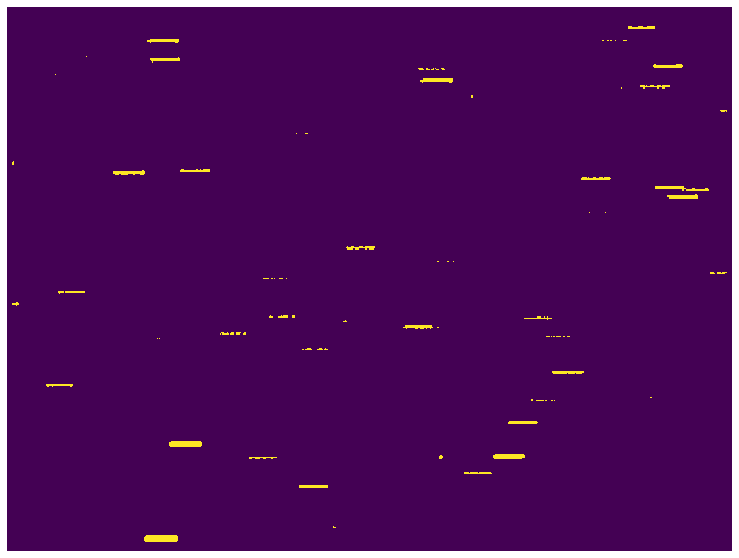

In [25]:
plt.figure(figsize=(15,10))
plt.imshow(pred_image, interpolation='None')
plt.axis('off')
plt.show()

Clearly there are a high number of false detections : there are only three satellites in this image.

In [26]:
print(train_annotation[sequence_id][frame_id])

[[510.956787109375, 397.0206298828125], [577.42578125, 398.102783203125], [382.2294921875, 396.5255126953125]]


 This very basic classifier confuses the star traces for satellites. 

 ## Example of correct detection
 However, we can see an example of correct detection in this frame.

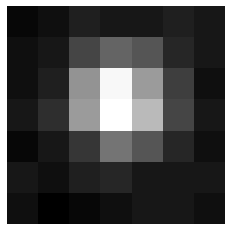

In [19]:
true_x=int(train_annotation[sequence_id][frame_id][2][1]+.5)
true_y=int(train_annotation[sequence_id][frame_id][2][0]+.5)
plt.imshow(extract_neighborhood(true_x,true_y,target_image,3).reshape((7,7)), cmap='gray')
plt.axis('off')
plt.show()

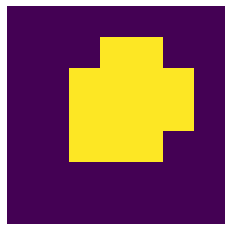

In [20]:
plt.imshow(extract_neighborhood(true_x, true_y, pred_image, 3).reshape((7,7)))
plt.axis('off')
plt.show()

## Extracting the centroids of the detected objects
Here we attempt to simplify this classification by assuming that multiple neighboring detected pixels belong to the same object. We will create a submission file based on the centroid of these objects, i.e. the mean (x,y) coordinate vector the pixels of each connected component. The connected components are extracted using the `scikit-image` functionalities.

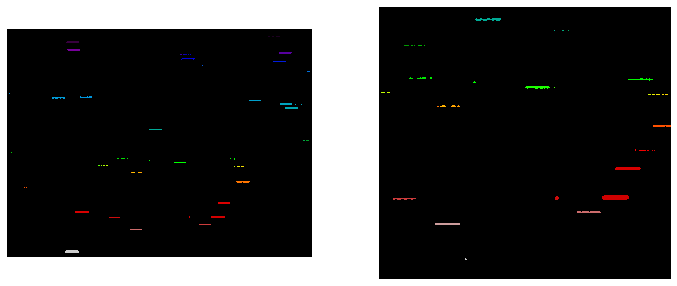

In [21]:
conn_comp=measure.label(pred_image,background=0)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(conn_comp,cmap='nipy_spectral', interpolation='None')
plt.axis('off')
plt.subplot(122)
plt.imshow(conn_comp[200:500,200:500],cmap='nipy_spectral', interpolation='None')
plt.axis('off')
plt.show()

In [22]:
def extract_centroids(pred, bg):
    conn_comp=measure.label(pred, background=bg)
    object_dict=defaultdict(list) #Keys are the indices of the connected components and values are arrrays of their pixel coordinates 
    for (x,y),label in np.ndenumerate(conn_comp):
            if label != bg:
                object_dict[label].append([x,y])
    # Mean coordinate vector for each object, except the "0" label which is the background
    centroids={label: np.mean(np.stack(coords),axis=0) for label,coords in object_dict.items()}
    object_sizes={label: len(coords) for label,coords in object_dict.items()}
    return centroids, object_sizes

In [23]:
centroids,sizes = extract_centroids(pred_image,0)
print(len(centroids.values()))
print(centroids[1])

85
[ 17.61538462 559.8974359 ]


## Filtering the large objects out
We can try to filter out the larger objects which are obviously not viable candidates.

In [24]:
print("Size of detected objects:",sizes.values())

Size of detected objects: dict_values([39, 86, 2, 1, 2, 1, 3, 1, 82, 86, 8, 5, 4, 3, 6, 1, 89, 51, 1, 2, 12, 1, 3, 5, 63, 74, 67, 107, 82, 1, 1, 56, 1, 2, 1, 7, 15, 5, 2, 1, 4, 1, 6, 18, 17, 5, 14, 4, 31, 4, 59, 1, 11, 5, 9, 5, 3, 1, 2, 4, 2, 3, 1, 1, 9, 8, 4, 2, 80, 28, 1, 2, 7, 2, 2, 1, 78, 140, 134, 13, 35, 47, 50, 3, 174])


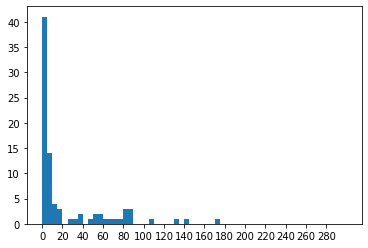

In [25]:
plt.hist(sizes.values(),60,[0, 300])
plt.xticks(np.arange(0,300,20))
plt.show()

In [26]:
def filter_large_objects(centroids,object_sizes, max_size):
    small_centroids={}
    for label,coords in centroids.items():
            if object_sizes[label] <= max_size:
                small_centroids[label]=coords
    return small_centroids

small_centroids=filter_large_objects(centroids,sizes,2)
print(len(small_centroids.keys()))

29


## Converting the prediction into a valid submission file
First we will run the whole classification+filtering process on one frame of the test set.

In [27]:
def predict_objects(sequence_id, frame_id, model, radius, max_size):
    test_image = plt.imread(f"test/{sequence_id}/{frame_id}.png")
    test_pred=classify_image(test_image, model, radius)
    test_centroids, test_sizes = extract_centroids(test_pred, 0)
    test_centroids = filter_large_objects(test_centroids, test_sizes, max_size)
    # Switch x and y coordinates for submission
    if len(test_centroids.values()) > 0:
        sub=np.concatenate([c[np.array([1,0])].reshape((1,2)) for c in test_centroids.values()])
        #np array converted to list for json seralization, truncated to the first 30 elements
        return sub.tolist()[0:30]
    else:
        return []

In [28]:
sub_list=predict_objects(1,1,RF,radius,1)
print(sub_list[0:5])

[[188.0, 13.0], [477.0, 18.0], [477.0, 22.0], [564.0, 43.0], [175.0, 87.0]]


We can then include this into a list of dictionaries with the proper keys to identify the sequence and frame. For a submission on the full data set, this list will need to be completed with the other sequences and frames. Furthermore as the number of submissions is limited to 30 per frame, we show here how you could submit only the first 30 elements in the example frame. We will create empty submissions for all of the other sequences and frames for the purpose of demonstration.

In [29]:
submission=[]
for s in range(1,3201):
    for fr in range(1,6):
        if s == sequence_id and fr == frame_id:
            submission.append({"sequence_id" : s, 
                                    "frame" : fr, 
                                    "num_objects" : len(sub_list), 
                                    "object_coords" : sub_list})
        else:
            submission.append({"sequence_id" : s,
                                    "frame" : fr,
                                    "num_objects" : 0,
                                    "object_coords" : []})
with open('my_submission.json', 'w') as outfile:
    json.dump(submission, outfile)

## Optional : classify the entire test data set
To speed things up we can use `multiprocessing` to run the `predict_objects` function on each pair of sequence ID and frame ID. The `nb_procs` parameter is set to 50 here but should be adapted to the available number of processing units available. 

In [ ]:
from multiprocessing import Pool
nb_procs = 50
p = Pool(processes=nb_procs)
sequence_list, frame_list = np.arange(1, 5121), np.arange(1, 6)
id_pair_list = list(itertools.product(sequence_list, frame_list))
sub_sequence = p.starmap(predict_objects, [(id_pair[0], id_pair[1], RF, radius, 1) for id_pair in id_pair_list])
p.close()

In [ ]:
sub_dict = {id_pair: sub for id_pair,sub in zip(id_pair_list, sub_sequence)}

submission=[]
for id_pair,sub_list in sub_dict.items():
            submission.append({"sequence_id" : int(id_pair[0]), 
                                    "frame" : int(id_pair[1]), 
                                    "num_objects" : len(sub_list), 
                                    "object_coords" : sub_list})
with open('my_submission.json', 'w') as outfile:
    json.dump(submission, outfile)